In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import os

In [4]:

# Directory containing the CSV files
folder_path = "C:/Users/anmol/Downloads/FootballData"

# Create a dictionary to store DataFrames
dataframes = {}

# Load each CSV file into a DataFrame
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(folder_path, filename)
        dataframes[filename] = pd.read_csv(file_path)



In [5]:
if "clubs.csv" in dataframes:
    clubs_df = dataframes["clubs.csv"]



In [6]:
top_league_ids = ['GB1', 'L1', 'FR1', 'ES1', 'IT1']

# Filter the DataFrame
clubs_df = clubs_df[clubs_df["domestic_competition_id"].isin(top_league_ids)]

# Reset the index and drop the old index
clubs_df = clubs_df.reset_index(drop=True)

# Save the filtered DataFrame to CSV
clubs_df.to_csv('clubs.csv', index=False)



In [ ]:
#filtering transfers from 2009

In [7]:
if "transfers.csv" in dataframes:
    transfers_df = dataframes["transfers.csv"]

# transfers_df= transfers_df[transfers_df["transfer_season"].split("/")]


transfers_df['adjusted_year'] = transfers_df['transfer_season'].apply(
    lambda x: 1900 + int(x.split('/')[0]) if int(x.split('/')[0]) > 50 else 2000 + int(x.split('/')[0])
)
transfers_df= transfers_df[transfers_df["adjusted_year"]>=2009]

transfers_df.to_csv("transfers_updated.csv", index= False)



In [26]:
# Ensure that 'transfers_updated.csv' is loaded correctly from dataframes
if "transfers_updated.csv" in dataframes:
    transfers_updated_df = dataframes["transfers_updated.csv"]

transfers_updated_df = transfers_updated_df[transfers_updated_df['transfer_fee'] > 0]
transfers_updated_df = transfers_updated_df.drop_duplicates(subset=['to_club_id', 'transfer_fee'])


    
    # Proceed with the calculation of the highest spending clubs
spending_df = transfers_updated_df.groupby("to_club_id")['transfer_fee'].sum().sort_values(ascending=False)
    
    # Reset index so that 'to_club_id' becomes a column
spending_df = spending_df.reset_index()

    # Merge 'spending_df' with 'clubs_df' to get the club names
spending_df = pd.merge(spending_df, clubs_df[['club_id', 'name', 'domestic_competition_id']], 
                           left_on='to_club_id', right_on='club_id', how='left')
#could also use other types of join here insteadd of dropping below

    # Drop the 'club_id' column from the merged result (if not needed)
    # spending_df = spending_df.drop(columns=['club_id'])
spending_df = spending_df.dropna(subset=['name'])
spending_df = spending_df.reset_index()

    

    # Display the resulting spending_df
spending_df.to_csv("spending.csv", index= False)


In [ ]:
#spending visualization


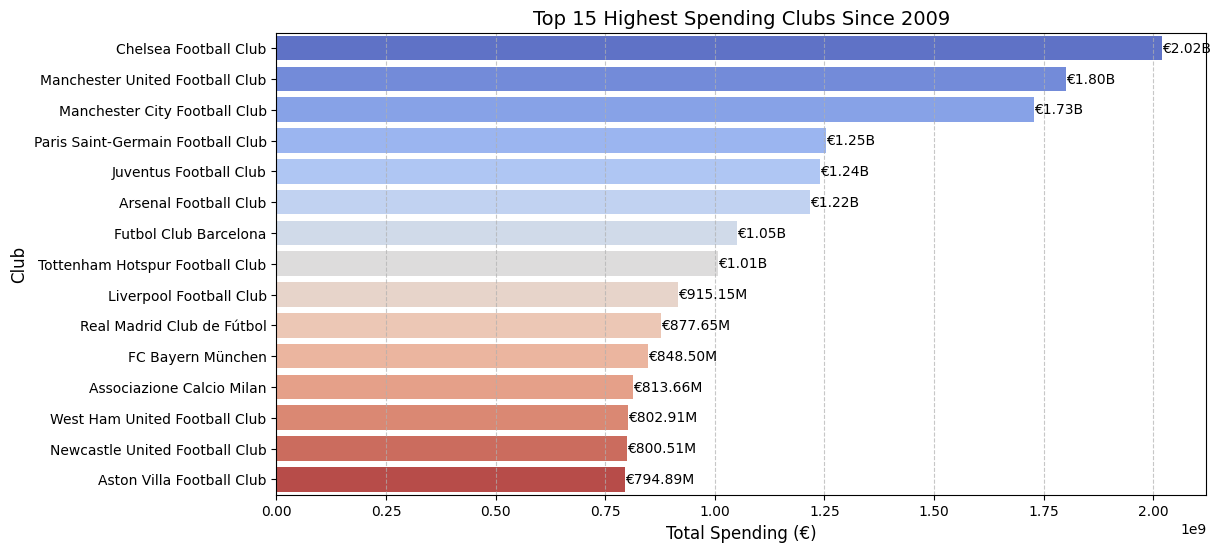

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the top 15 spending clubs
top_15_clubs = spending_df.nlargest(15, "transfer_fee")

# Format transfer_fee for readability (e.g., 1.2B instead of raw numbers)
top_15_clubs["formatted_fee"] = top_15_clubs["transfer_fee"].apply(lambda x: f"€{x / 1e9:.2f}B" if x >= 1e9 else f"€{x / 1e6:.2f}M")

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot with corrected 'hue' usage
sns.barplot(
    data=top_15_clubs, 
    y="name", 
    x="transfer_fee", 
    hue="name",  # Fix for FutureWarning
    palette="coolwarm", 
    legend=False
)

# Labels and Title
plt.xlabel("Total Spending (€)", fontsize=12)
plt.ylabel("Club", fontsize=12)
plt.title("Top 15 Highest Spending Clubs Since 2009", fontsize=14)

# Add text labels on bars
for index, value in enumerate(top_15_clubs["transfer_fee"]):
    plt.text(value, index, top_15_clubs["formatted_fee"].iloc[index], va='center', fontsize=10)

# Formatting
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("top_15_spending_clubs.png", dpi=300, bbox_inches="tight")  # Saves as PNG

plt.show()


In [9]:
#spending.csv has the total spending of all clubs and their corresponding domesticcomp id
#from here we can find out top N highest spenders across leagues.
#and, we can also find highest spenders in a specific league from here

In [10]:
#highest spending leagues
#mapping
competition= {
    "IT1": "SerieA",
    "GB1": "EPL",
    "ES1": "Laliga",
    "FR1": "Ligue 1",
    "L1": "Bundesliga"
}
#creating a new column in spending_df called league. basically left part is the creation
#of the new columnand right part is the value IT1= SerieA
spending_df["league"] = spending_df["domestic_competition_id"].map(competition)
#creating a new spending_leagues dataframe to store the total
spending_leagues_df = spending_df.groupby("league")["transfer_fee"].sum().sort_values(ascending=False)
#making it into a df
spending_leagues_df = spending_leagues_df.reset_index()
#formatting the spending to B and M
spending_leagues_df["transfer_fee"]= spending_leagues_df["transfer_fee"].apply(lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}"))
spending_leagues_df.to_csv("spending_leagues.csv", index= False)





In [ ]:
#visualization for highest spending leagues


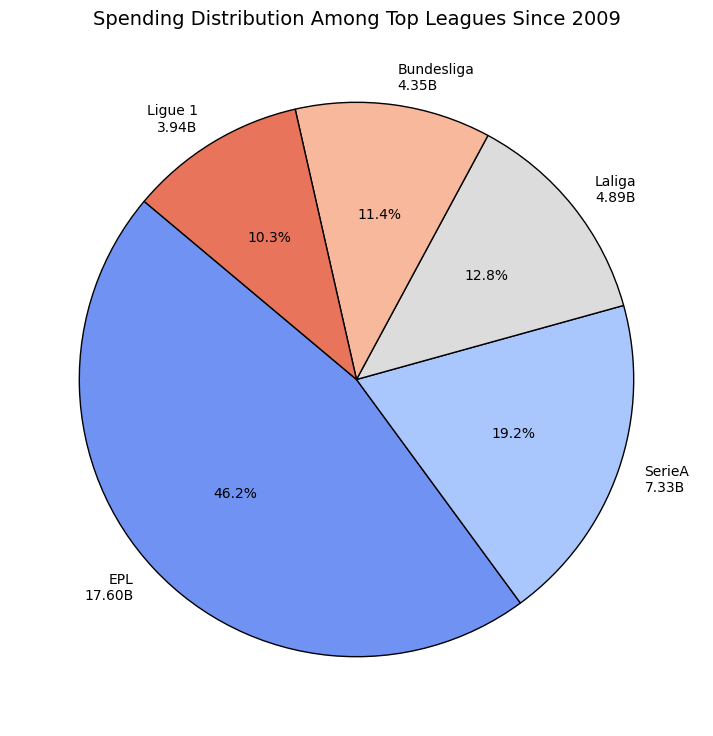

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert transfer_fee to numeric values
spending_leagues_df["transfer_fee_numeric"] = spending_leagues_df["transfer_fee"].replace(
    {"B": "e9", "M": "e6"}, regex=True).astype(float)

# Define colors
colors = sns.color_palette("coolwarm", len(spending_leagues_df))

# Create labels with actual values
labels = [
    f"{league}\n{fee}" for league, fee in zip(spending_leagues_df["league"], spending_leagues_df["transfer_fee"])
]

# Plot Pie Chart
plt.figure(figsize=(9, 9))
plt.pie(spending_leagues_df["transfer_fee_numeric"], labels=labels, 
        autopct="%1.1f%%", colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})

# Title
plt.title("Spending Distribution Among Top Leagues Since 2009", fontsize=14)

# Save the visualization
plt.savefig("spending_leagues_pie_chart_with_values.png", dpi=300, bbox_inches="tight")

# Show Plot
plt.show()


In [11]:
#now lets create highest spenders in a particular league

In [12]:
#highest spenders epl

In [19]:
if "spending.csv" in dataframes:
    spending_df= dataframes["spending.csv"]
    
epl_spending_df = spending_df[spending_df['domestic_competition_id'] == "GB1"]


epl_spending_df= epl_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending= False)
epl_spending_df= epl_spending_df.reset_index()
epl_spending_df["transfer_fee"]= epl_spending_df["transfer_fee"].apply(lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}"))


In [ ]:
#visualise the highest epl spenders

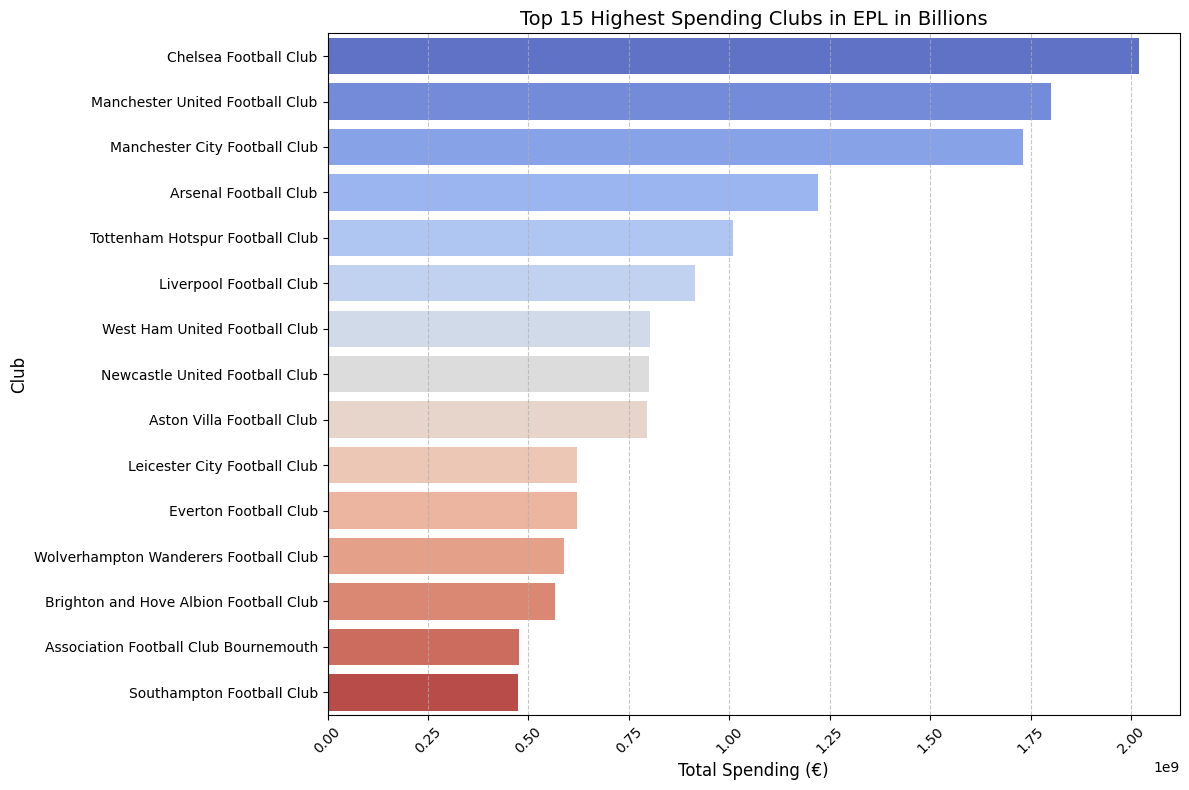

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'transfer_fee' back to numeric by removing 'B' and 'M' and handling them correctly
epl_spending_df['transfer_fee_numeric'] = epl_spending_df['transfer_fee'].apply(lambda x: float(x.replace('B', '').replace('M', '').strip()) * (1e9 if 'B' in x else (1e6 if 'M' in x else 1)))

# Get the top 15 spending teams in EPL
top_epl_spending_df = epl_spending_df.nlargest(15, "transfer_fee_numeric")

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_epl_spending_df, y="name", x="transfer_fee_numeric", palette="coolwarm", hue="name", legend=False)

# Add labels and title
plt.xlabel("Total Spending (€)", fontsize=12)
plt.ylabel("Club", fontsize=12)
plt.title("Top 15 Highest Spending Clubs in EPL in Billions", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Save the plot to a file
plt.tight_layout()
plt.savefig("top_15_epl_spending.png", format="png")

# Show the plot
plt.show()


In [14]:
#higest spender laliga

In [20]:
if "spending.csv" in dataframes:
    spending_df= dataframes["spending.csv"]
    
es_spending_df = spending_df[spending_df['domestic_competition_id'] == "ES1"]


es_spending_df= es_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending= False)
es_spending_df= es_spending_df.reset_index()
es_spending_df["transfer_fee"]= es_spending_df["transfer_fee"].apply(lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}"))



In [37]:
#laliga visualisation


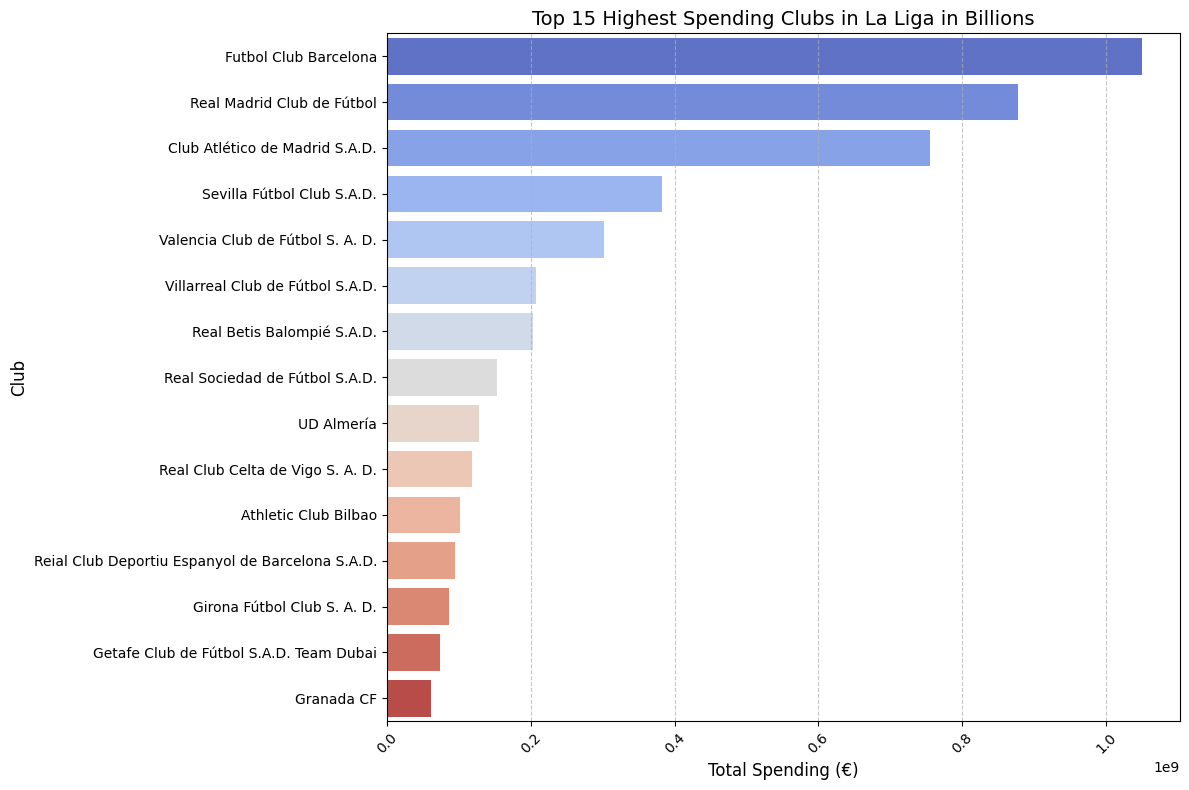

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter La Liga spending data (ES1)
es_spending_df = spending_df[spending_df['domestic_competition_id'] == "ES1"]

# Group by club name and sum the transfer fees, then sort in descending order
es_spending_df = es_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending=False)
es_spending_df = es_spending_df.reset_index()

# Format the transfer fee to show in billions or millions
es_spending_df["transfer_fee"] = es_spending_df["transfer_fee"].apply(
    lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}")
)

# Convert 'transfer_fee' back to numeric for plotting
es_spending_df['transfer_fee_numeric'] = es_spending_df['transfer_fee'].apply(
    lambda x: float(x.replace('B', '').replace('M', '').strip()) * (1e9 if 'B' in x else (1e6 if 'M' in x else 1))
)

# Get the top 15 spending teams in La Liga
top_es_spending_df = es_spending_df.nlargest(15, "transfer_fee_numeric")

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_es_spending_df, y="name", x="transfer_fee_numeric", palette="coolwarm", hue="name", legend=False)

# Add labels and title
plt.xlabel("Total Spending (€)", fontsize=12)
plt.ylabel("Club", fontsize=12)
plt.title("Top 15 Highest Spending Clubs in La Liga in Billions", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Save the plot to a file
plt.tight_layout()
plt.savefig("top_15_la_liga_spending.png", format="png")

# Show the plot
plt.show()


In [16]:
#highest spenders serie a

In [22]:
if "spending.csv" in dataframes:
    spending_df= dataframes["spending.csv"]
    
it_spending_df = spending_df[spending_df['domestic_competition_id'] == "IT1"]


it_spending_df= it_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending= False)
it_spending_df= it_spending_df.reset_index()
it_spending_df["transfer_fee"]= it_spending_df["transfer_fee"].apply(lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}"))



In [ ]:
#visualisation for serie a

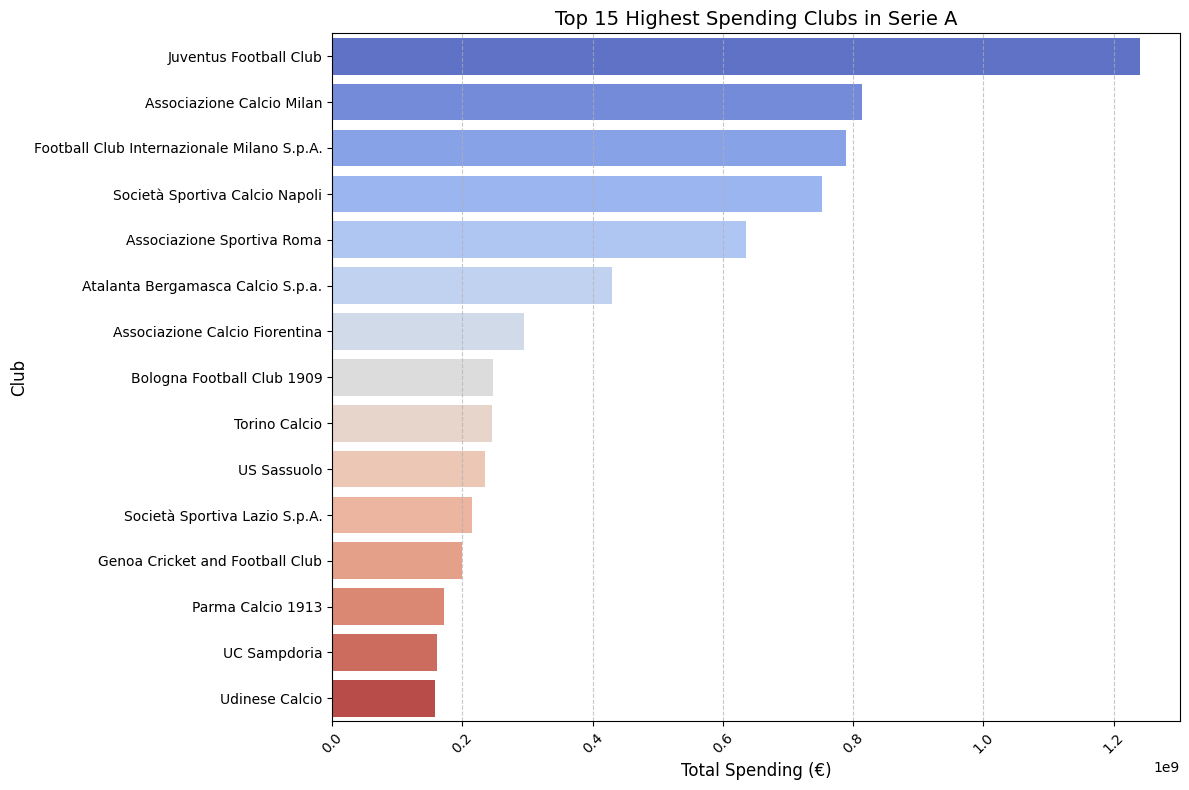

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter Serie A spending data (IT1)
it_spending_df = spending_df[spending_df['domestic_competition_id'] == "IT1"]

# Group by club name and sum the transfer fees, then sort in descending order
it_spending_df = it_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending=False)
it_spending_df = it_spending_df.reset_index()

# Format the transfer fee to show in billions or millions
it_spending_df["transfer_fee"] = it_spending_df["transfer_fee"].apply(
    lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}")
)

# Convert 'transfer_fee' back to numeric for plotting
it_spending_df['transfer_fee_numeric'] = it_spending_df['transfer_fee'].apply(
    lambda x: float(x.replace('B', '').replace('M', '').strip()) * (1e9 if 'B' in x else (1e6 if 'M' in x else 1))
)

# Get the top 15 spending teams in Serie A
top_it_spending_df = it_spending_df.nlargest(15, "transfer_fee_numeric")

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_it_spending_df, y="name", x="transfer_fee_numeric", palette="coolwarm", hue="name", legend=False)

# Add labels and title
plt.xlabel("Total Spending (€)", fontsize=12)
plt.ylabel("Club", fontsize=12)
plt.title("Top 15 Highest Spending Clubs in Serie A", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Save the plot to a file
plt.tight_layout()
plt.savefig("top_15_serie_a_spending.png", format="png")

# Show the plot
plt.show()


In [ ]:
#highest spenders bundesliga

In [23]:
if "spending.csv" in dataframes:
    spending_df= dataframes["spending.csv"]
    
ger_spending_df = spending_df[spending_df['domestic_competition_id'] == "L1"]


ger_spending_df= ger_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending= False)
ger_spending_df= ger_spending_df.reset_index()
ger_spending_df["transfer_fee"]= ger_spending_df["transfer_fee"].apply(lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}"))



In [42]:
#bundesliga visualisation


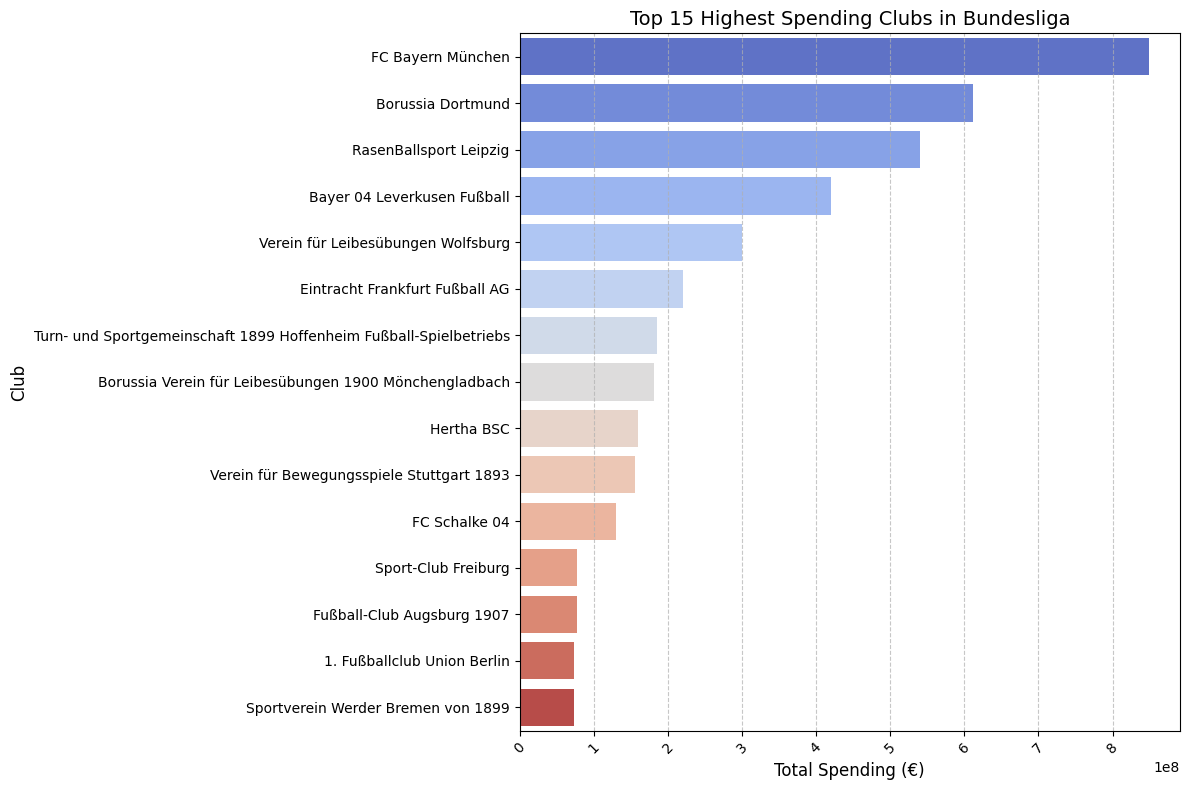

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter Bundesliga spending data (L1)
ger_spending_df = spending_df[spending_df['domestic_competition_id'] == "L1"]

# Group by club name and sum the transfer fees, then sort in descending order
ger_spending_df = ger_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending=False)
ger_spending_df = ger_spending_df.reset_index()

# Format the transfer fee to show in billions or millions
ger_spending_df["transfer_fee"] = ger_spending_df["transfer_fee"].apply(
    lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}")
)

# Convert 'transfer_fee' back to numeric for plotting
ger_spending_df['transfer_fee_numeric'] = ger_spending_df['transfer_fee'].apply(
    lambda x: float(x.replace('B', '').replace('M', '').strip()) * (1e9 if 'B' in x else (1e6 if 'M' in x else 1))
)

# Get the top 15 spending teams in Bundesliga
top_ger_spending_df = ger_spending_df.nlargest(15, "transfer_fee_numeric")

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_ger_spending_df, y="name", x="transfer_fee_numeric", palette="coolwarm", hue="name", legend=False)

# Add labels and title
plt.xlabel("Total Spending (€)", fontsize=12)
plt.ylabel("Club", fontsize=12)
plt.title("Top 15 Highest Spending Clubs in Bundesliga", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Save the plot to a file
plt.tight_layout()
plt.savefig("top_15_bundesliga_spending.png", format="png")

# Show the plot
plt.show()


In [24]:
#highest spenders france

In [25]:
if "spending.csv" in dataframes:
    spending_df= dataframes["spending.csv"]
    
fr_spending_df = spending_df[spending_df['domestic_competition_id'] == "FR1"]


fr_spending_df= fr_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending= False)
fr_spending_df= fr_spending_df.reset_index()
fr_spending_df["transfer_fee"]= fr_spending_df["transfer_fee"].apply(lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}"))


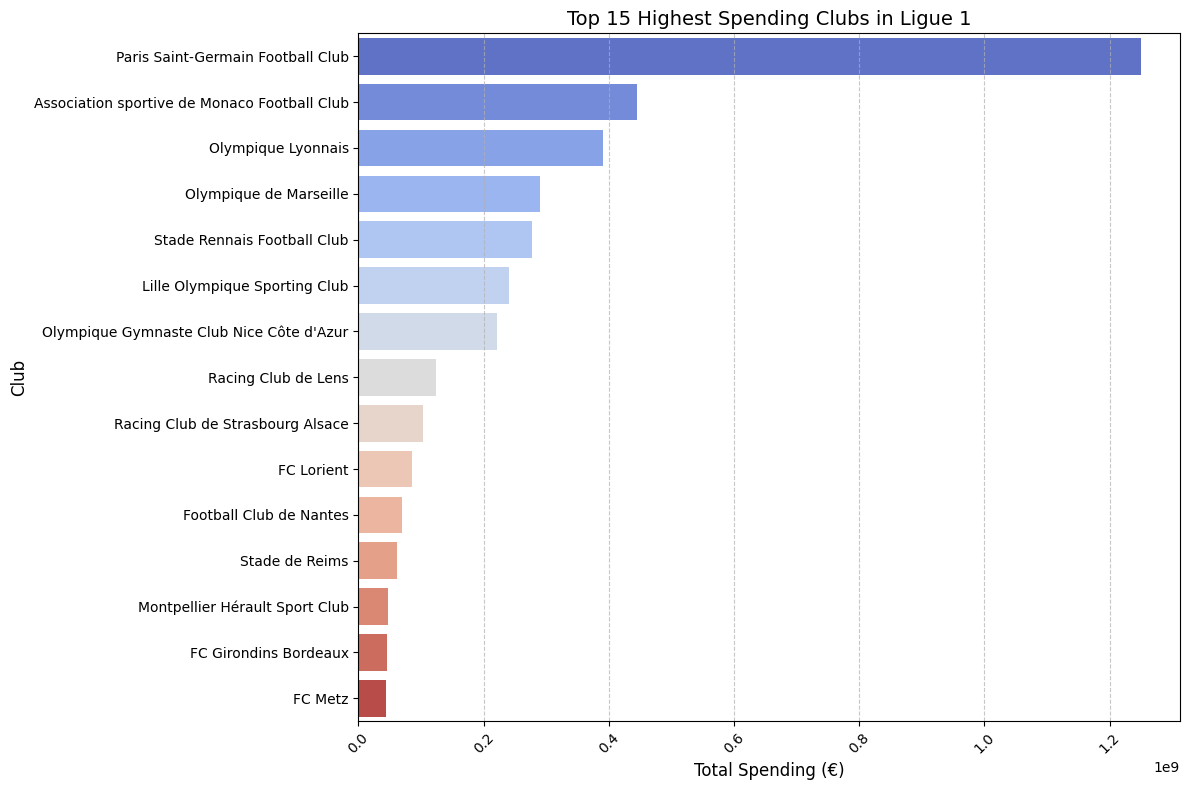

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter Ligue 1 spending data (FR1)
fr_spending_df = spending_df[spending_df['domestic_competition_id'] == "FR1"]

# Group by club name and sum the transfer fees, then sort in descending order
fr_spending_df = fr_spending_df.groupby("name")["transfer_fee"].sum().sort_values(ascending=False)
fr_spending_df = fr_spending_df.reset_index()

# Format the transfer fee to show in billions or millions
fr_spending_df["transfer_fee"] = fr_spending_df["transfer_fee"].apply(
    lambda x: f"{x / 1e9:.2f}B" if x >= 1e9 else (f"{x / 1e6:.2f}M" if x >= 1e6 else f"{x:.2f}")
)

# Convert 'transfer_fee' back to numeric for plotting
fr_spending_df['transfer_fee_numeric'] = fr_spending_df['transfer_fee'].apply(
    lambda x: float(x.replace('B', '').replace('M', '').strip()) * (1e9 if 'B' in x else (1e6 if 'M' in x else 1))
)

# Get the top 15 spending teams in Ligue 1
top_fr_spending_df = fr_spending_df.nlargest(15, "transfer_fee_numeric")

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_fr_spending_df, y="name", x="transfer_fee_numeric", palette="coolwarm", hue="name", legend=False)

# Add labels and title
plt.xlabel("Total Spending (€)", fontsize=12)
plt.ylabel("Club", fontsize=12)
plt.title("Top 15 Highest Spending Clubs in Ligue 1", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Save the plot to a file
plt.tight_layout()
plt.savefig("top_15_ligue1_spending.png", format="png")

# Show the plot
plt.show()
